# Plotting Functions

In [1]:
import numpy as np
import csv
import math
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# from scipy.interpolate import make_interp_spline
from typing import Any, Callable, Dict, List, Optional, Union
import glob
import os
# from matplotlib.ticker import ScalarFormatter
import statistics
from matplotlib.ticker import FormatStrFormatter


def parse_csv(filename):
    """
    Opens the 'filename' csv, reads the data and returns the following lists:
    
    Returns:
        walltime, steps, reward_values 
    """
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        rowcnt = 0
        walltime = []
        steps = []
        reward_values = []
        for row in reader:
            # Ignores the first row and then just adds column 1's value to x axis and column 2's value to
            # y axis
            if rowcnt>0:
                walltime.append(np.float32(row[0]))
                steps.append(np.int32(row[1]))
                reward_values.append(np.float32(row[2]))
                rowcnt+=1
            else:
                rowcnt+=1
    
        return walltime, steps, reward_values 
    
def smooth(scalars, weight: float):
    """
    EMA implementation according to
    https://github.com/tensorflow/tensorboard/blob/34877f15153e1a2087316b9952c931807a122aa7/tensorboard/components/vz_line_chart2/line-chart.ts#L699
    """
    last = 0
    smoothed = []
    num_acc = 0
    for next_val in scalars:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - math.pow(weight, num_acc)
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)

    return smoothed


def plot_from_csv(filename, smoothing_weight, xlabel, ylabel, title, ylim = None, grid = True, zero =False, smoothing = True, save = True):
    """
    Generate a graph from a csv file
    Parameters:
        filename: The path to the file, eg csv/my_data.csv
        smoothing wegith: smoothing weight to apply
        xlabel: label of the x-axis
        ylabel: label of the y-axis
        title: Title of the plot
        ylim: List of two values, lower and upper bounds of the y-axis, eg. [0, 1]
        grid: bool, whether or not the grid should be displayed
        zero: bool whether or not a solid 0-level line should be displayed
        smoothing: bool, whether or not smoothing should be applied. If false the smoothing_weight will not do anything
        save: Whether or not to save the figure. By default will save as filename.png
    """
    x,y = parse_csv(filename)
    
    figure(figsize=(10, 5), dpi=90)
    if not smoothing:
        plt.plot(x,y, label = "raw")
    else:
        plt.plot(x,y, label = "raw", alpha = 0.4)
        y_s = smooth(y, smoothing_weight)
        plt.plot(x,y_s, label = "smoothed")
        plt.legend(loc = "upper right")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])

    if grid:
        plt.grid(alpha = 0.3)

    if zero:
        plt.axhline(0, color = "black", linewidth = 0.5)
    
    if save:
        plt.savefig(f"figs/{filename[4:-4]}.png")

def plot_target_network_updates(this_run_directory:str):
    return np.load(this_run_directory)



def plot_from_datasets(x,y, smoothing_weight, xlabel, ylabel, title, ylim = None, grid = True, zero =False, smoothing = True, save = False, filename = None, ignore_first = 0, target_indices = None):
    
    # figure(figsize=(4, 3), dpi=300)
    figure(dpi=300)
    if ignore_first>0:
        y = y[ignore_first:]
        x = x[ignore_first:]

    if not smoothing:
        plt.plot(x,y, label = "raw")
        if target_indices is not None:
            interp_x = np.interp(target_indices, x, x)
            interp_y = np.interp(target_indices, x, y)
            plt.scatter(interp_x, interp_y, color='blue', marker='x')
    else:
        plt.plot(x,y, label = "raw", alpha = 0.3)
        y_s = smooth(y, smoothing_weight)
        plt.plot(x,y_s, label = "smoothed")
        
        if target_indices is not None:
            interp_x = np.interp(target_indices, x, x)
            interp_y = np.interp(target_indices, x, y_s)
            plt.scatter(interp_x, interp_y, color='blue', marker='.', label = "Target Network Update", zorder=4)

        plt.legend(loc = "upper left")

    

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)


    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])

    if grid:
        plt.grid(alpha = 0.3)

    if zero:
        plt.axhline(0, color = "black", linewidth = 0.5)

    if save:
        assert filename is not None, "You need a filename to save the plot as"
        plt.savefig(f"figs/{filename}.png")


def plot_comparative(graph_to_plot: str,start_time:int,  end_time: int, smoothing_weight = 0.6):
    filenames = []
    path = f'csv/{graph_to_plot}/*.csv'
    for fname in glob.glob(path):
        filenames.append(fname)

    yvalues_raw = []
    xs = []

    
    for fname in filenames:
            x, y = parse_csv(fname)
            yvalues_raw.append(y)
            xs.append(x)


    y_smoothed = []
    for yraw in yvalues_raw:
        y_smoothed.append(smooth(yraw, smoothing_weight))

    # assert len(x)>= end_time, f"You are trying to plot more values than available, max number is {len(x)}, you are trying {end_time}"
    
    # Plot only for all available values:
    # Find shortest dataset:
    fig, ax = plt.subplots()       
    ylims = []
    yminvals = []
    ymaxvals = []
    for ys,fname,x in zip(y_smoothed,filenames,xs):
        ax.plot(x, ys, label = fname)
        v = find_closest_value_index(end_time, x)
        ylims.append(ys[v])
        yminvals.append(min(ys[:v]))
        ymaxvals.append(max(ys[:v]))

        
    # Calculate y limits:
    # Find index of max and index of min
    # If index of max - index of min -> increasing gradient else decreasing 
    ymax = max(ymaxvals)
    ymin = min(yminvals)
    print(ymax)
    print(ymin)

    ax.legend()
    plt.xlim(start_time,end_time)
    plt.ylim(ymin-statistics.stdev(y_smoothed[0]), ymax+statistics.stdev(y_smoothed[0]))
    plt.grid(alpha = 0.3)
    plt.show()

def find_closest_value_index(value, value_list):
    closest_index = min(range(len(value_list)), key=lambda i: abs(value_list[i] - value))
    return closest_index


# Generating Results Figures

### Global Variables

In [2]:
smoothing_weight = 0.0
save = False

In [3]:
# WIP section
sub_paths = []
path = 'csv/*.csv'
for fname in glob.glob(path):
    sub_paths.append(fname)

print(sub_paths)

xlabels = ["Steps"] * len(sub_paths)
ylabels = [x[4:-4] for x in sub_paths]
titles = [x[4:-4] for x in sub_paths]

for filename,xlabel,ylabel,title in zip(sub_paths,xlabels,ylabels,titles):
    try:
        _,x, y = parse_csv(filename)
    except:
        print(f"{filename} does not exist, passing over")
        continue
    
    plot_from_datasets(x,y,smoothing_weight, xlabel, ylabel, title, save=save, filename=filename[4:-4], ignore_first=0)

[]


### Plotting Target Net Updates

In [4]:
# # WIP section
# filenames = []
# path = 'csv/*.csv'
# for fname in glob.glob(path):
#     filenames.append(fname)

# xlabels = ["Steps"] * len(filenames)
# ylabels = [x[4:-4] for x in filenames]
# titles = [x[4:-4] for x in filenames]

# targtes = plot_target_network_updates("./results/10_08_08_57/target_updates.npy")
# print(targtes)

# for filename,xlabel,ylabel,title in zip(filenames,xlabels,ylabels,titles):
#     try:
#         x,y = parse_csv(filename)
#     except:
#         print(f"{filename} does not exist, passing over")
#         continue
    
#     plot_from_datasets(x,y,smoothing_weight, xlabel, ylabel, title, save=save, filename=filename[4:-4], ignore_first=0, target_indices=targtes)

# Generating Other Pictures

In [5]:
# import numpy as np
# import matplotlib.pyplot as plt

# # create a 5x5 array of zeros
# grid = np.zeros((5, 5))

# # set the top left 3x3 elements to 1 (shaded in blue)
# grid[:3, :3] = 1

# # create a figure and axes object
# fig, ax = plt.subplots()

# # plot the grid
# ax.imshow(grid, cmap='Blues')

# # add gridlines and set ticks to center of cells
# ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
# ax.set_xticks(np.arange(-0.5, 5, 1))
# ax.set_yticks(np.arange(-0.5, 5, 1))
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.tick_params(axis='both', which='both', length=0)


# # show the plot
# # plt.show()

# plt.savefig(f"figs/kernel_0.png")

### Comparing Different Figures

In [6]:
# # WIP section
# filenames = []
# path = 'csv/extrinsic_return/*.csv'
# for fname in glob.glob(path):
#     filenames.append(fname)


# x2,y2 = parse_csv(filenames[0]) #lr_1
# x,y = parse_csv(filenames[1]) #lr_0
# # _,y3 = parse_csv(filenames[2]) #lr_2
# # _, y4 = parse_csv(filenames[3])
# # print(filenames)

# t = 719
# wt=0.75
# fig, ax = plt.subplots()   


# ax.plot(x[0:t], smooth(y[0:t], wt), color='r', label = filenames[1])
# ax.plot(x2[0:t], smooth(y2[0:t],wt), color='g', label = filenames[0])
# # plt.plot(x[0:t], smooth(y3[0:t],wt), color='b', label = filenames[2])
# # plt.plot(x[0:t], smooth(y4[0:t],wt), color='purple', label = filenames[3])
# plt.legend()

# Generating Ablation Results

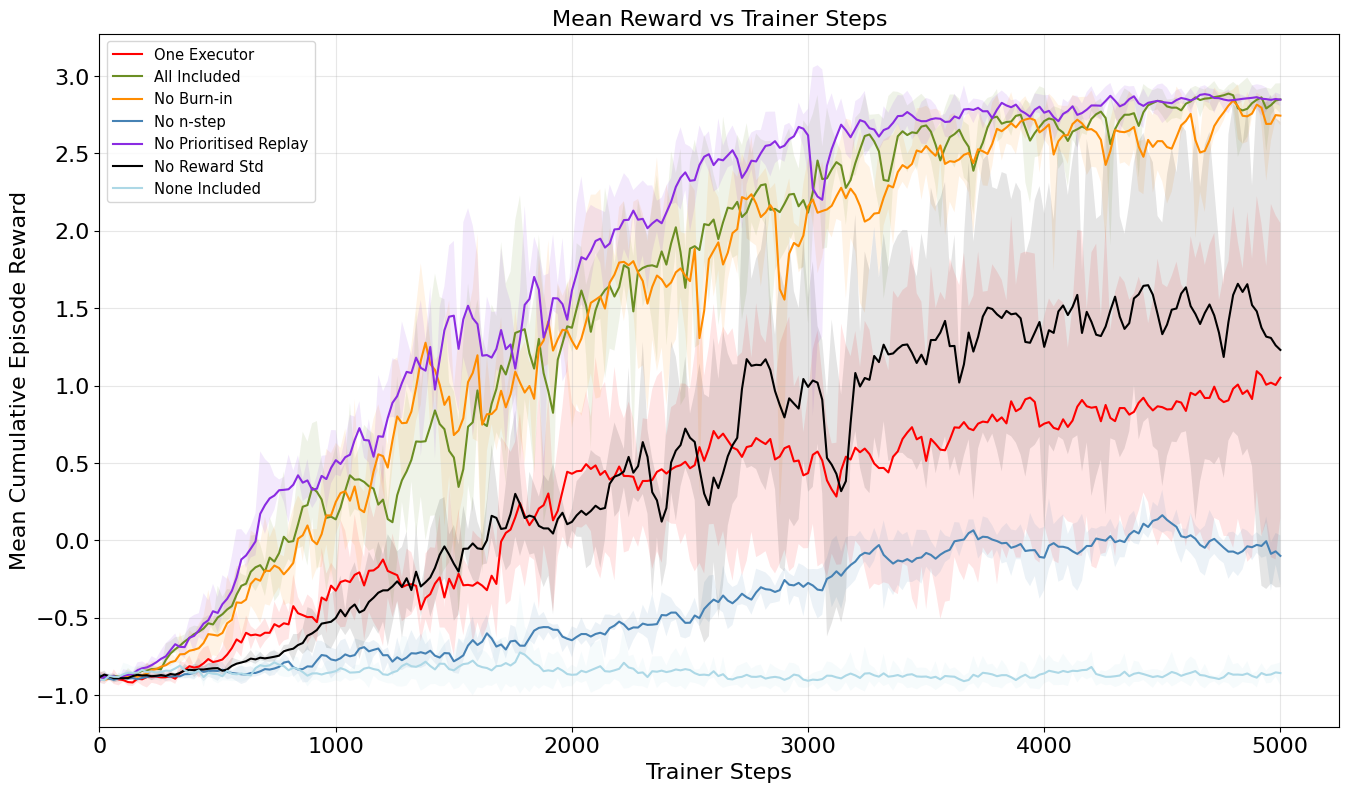

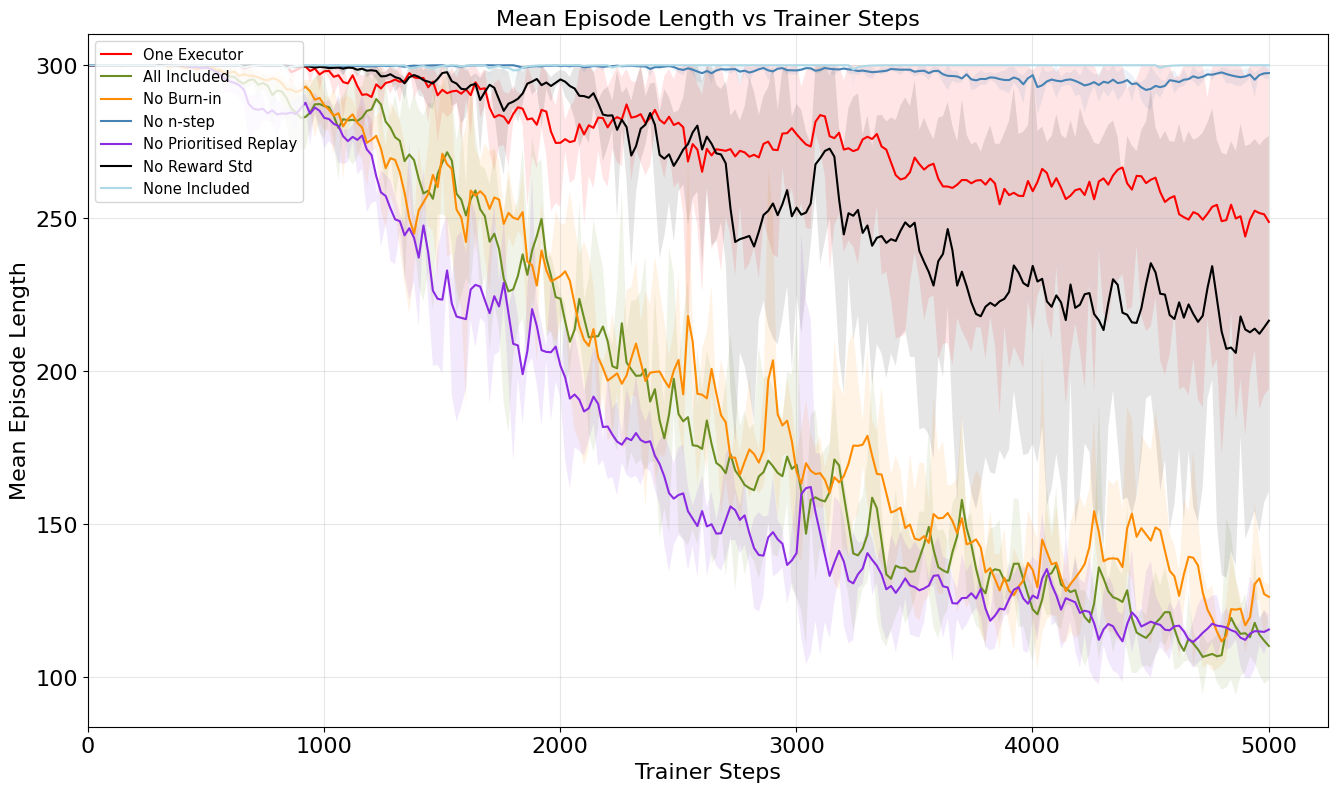

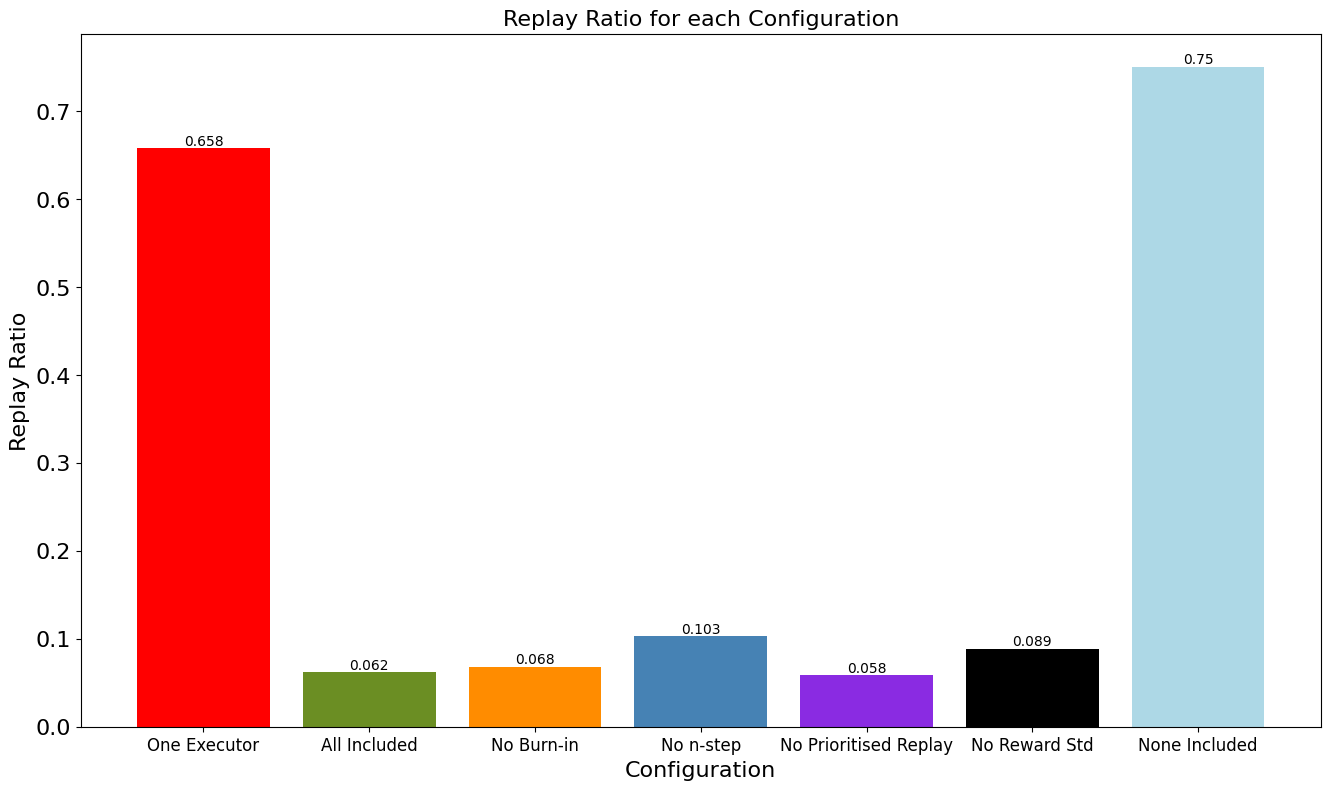

In [7]:
parent_dirs = ["rewards", "ep_len", "num_eps"]
fontsize = 16

num_ablation_studies = 3

for parent_dir in parent_dirs:
    sub_paths = []
    path = f'csv/{parent_dir}/*.csv'

    walltime_index = -1


    for fname in glob.glob(path):
        sub_paths.append(fname)

    # contains the sorted filenames. First three is for the same ablation type, as is the second three, etc
    sorted_sub_paths = sorted(sub_paths)
    labels = ["One Executor", "All Included", "No Burn-in", "No n-step", "No Prioritised Replay", "No Reward Std", "None Included"]
    colours = ["red", "olivedrab", "darkorange", "steelblue", "blueviolet", "black", "lightblue"]

    fig1, ax1 = plt.subplots()
    # fig2, ax2 = plt.subplots() #This is to plot it against  

    fig1.set_figwidth(16)
    # fig2.set_figwidth(16)
    fig1.set_figheight(9)
    # fig2.set_figheight(9)
    rr = []
    for ablation_item in range(0,21,3):
        y_list = []
        ablation_item_steps = []
        ablation_item_walltime = []

        current_filenames = sorted_sub_paths[ablation_item:ablation_item+3]
        # print(current_filenames)
        for study_number in range(num_ablation_studies):
            # Ablation item is essentially the starting index for the current run.
            walltime, steps, y = parse_csv(current_filenames[study_number])
            if parent_dir != "num_eps":
                y_list.append(y)
            else:
                y_list.append(y[-1])
            ablation_item_steps.append(steps)
            ablation_item_walltime.append(walltime)

        if parent_dir != "num_eps":
            mean_y = np.mean(np.stack(y_list, axis=0), axis=0)
            stddev_y = np.std(np.stack(y_list, axis=0), axis=0)
            # normalised_rewards = (mean_rewards - np.min(mean_rewards))/(np.max(mean_rewards) - np.min(mean_rewards))
            steps = ablation_item_steps[0]
            stacked_walltime = np.mean(np.stack(ablation_item_walltime, axis=0), axis=0)
            stacked_walltime = ((stacked_walltime - stacked_walltime[0])/60).astype(np.int32)
            
            fill_lower = mean_y-stddev_y
            fill_lower = np.clip(fill_lower, -1, 300)

            fill_upper = mean_y+stddev_y
            fill_upper = np.clip(fill_upper, -1, 300)

            ax1.plot(steps, smooth(mean_y, 0.5), label = labels[int(ablation_item/3)], color = colours[int(ablation_item/3)])
            ax1.fill_between(steps, fill_lower, fill_upper, facecolor=colours[int(ablation_item/3)], edgecolor=None, alpha=0.1)
        else:
            # print(f"For {labels[np.int32(ablation_item/3)]}:")
            # wanna plot a bar to show the replay ratio for each config
            # stacked = np.stack(y_list, axis=0)
            num_eps = np.array(np.mean(y_list))
            replay_ratio = 5001/num_eps

            rr.append(replay_ratio)


            

            
            # mean_num_eps = np.mean(np.stack(y_list, axis=0)[-1], axis=0)

            # print()
            
            # print(np.stack(y_list, axis=0)[-1])



    
    # leg2 = ax2.legend(loc = "upper left")


    ax1.grid(alpha = 0.3)
    ax1.set_xlabel("Trainer Steps", fontsize=fontsize)

    ax1.set_xbound(0)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    

    if parent_dir == "rewards":
        ax1.set_ylabel("Mean Cumulative Episode Reward", fontsize=fontsize)
        ax1.set_title("Mean Reward vs Trainer Steps", fontsize=fontsize)
        leg1 = ax1.legend(loc = "upper left", fontsize = 2/3*fontsize)
        fig1.savefig("figs/ablation_reward.pdf")
    elif parent_dir == "ep_len":
        ax1.set_ylabel("Mean Episode Length", fontsize=fontsize)
        ax1.set_title("Mean Episode Length vs Trainer Steps", fontsize=fontsize)
        leg1 = ax1.legend(loc = "upper left",fontsize = 2/3*fontsize)
        fig1.savefig("figs/ablation_eplen.pdf")
    else:
        bars1 = ax1.bar(labels, rr, color = colours)
        for bar1 in bars1:
            yval = bar1.get_height()
            ax1.text(bar1.get_x() + bar1.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')
        ax1.grid(False)
        ax1.set_ylabel("Replay Ratio", fontsize=fontsize)
        ax1.set_xlabel("Configuration", fontsize=fontsize)
        ax1.set_title("Replay Ratio for each Configuration", fontsize=fontsize)
        plt.xticks(fontsize=12)
        
        fig1.savefig("figs/ablation_replay_ratios_bars.pdf")

    
    # ax2.grid(alpha = 0.3)
    # ax2.set_xlabel("Walltime (Minutes)")
    # ax2.set_ylabel("Mean Cumulative Episode Reward")
    # ax2.set_title("Mean Reward vs Walltime")1
    # ax2.set_xbound(0)

    # stacked_rewards = np.stack(ablation_item_rewards, axis=0)
    # print(stacked_rewards.shape)

    
    # fig2.save



# 

# Plotting Results from Eval Eps

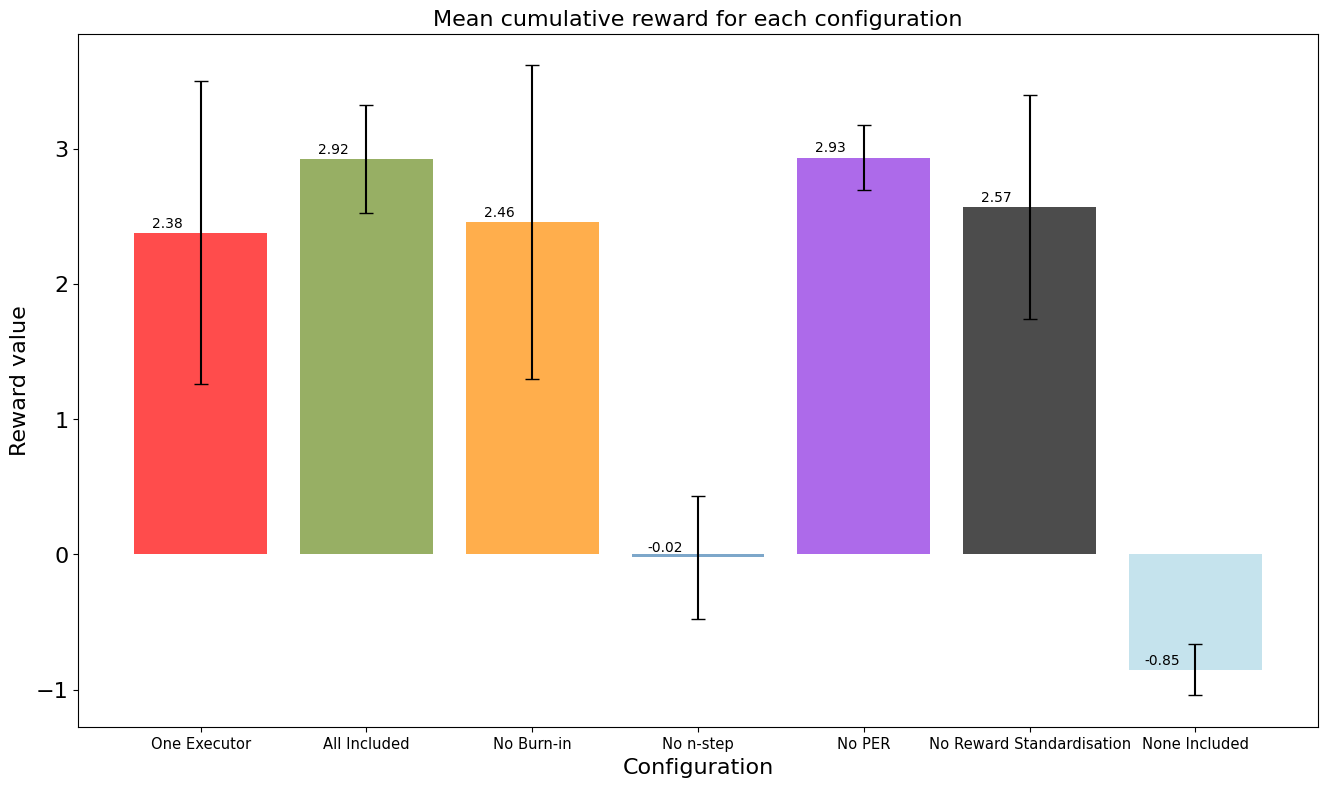

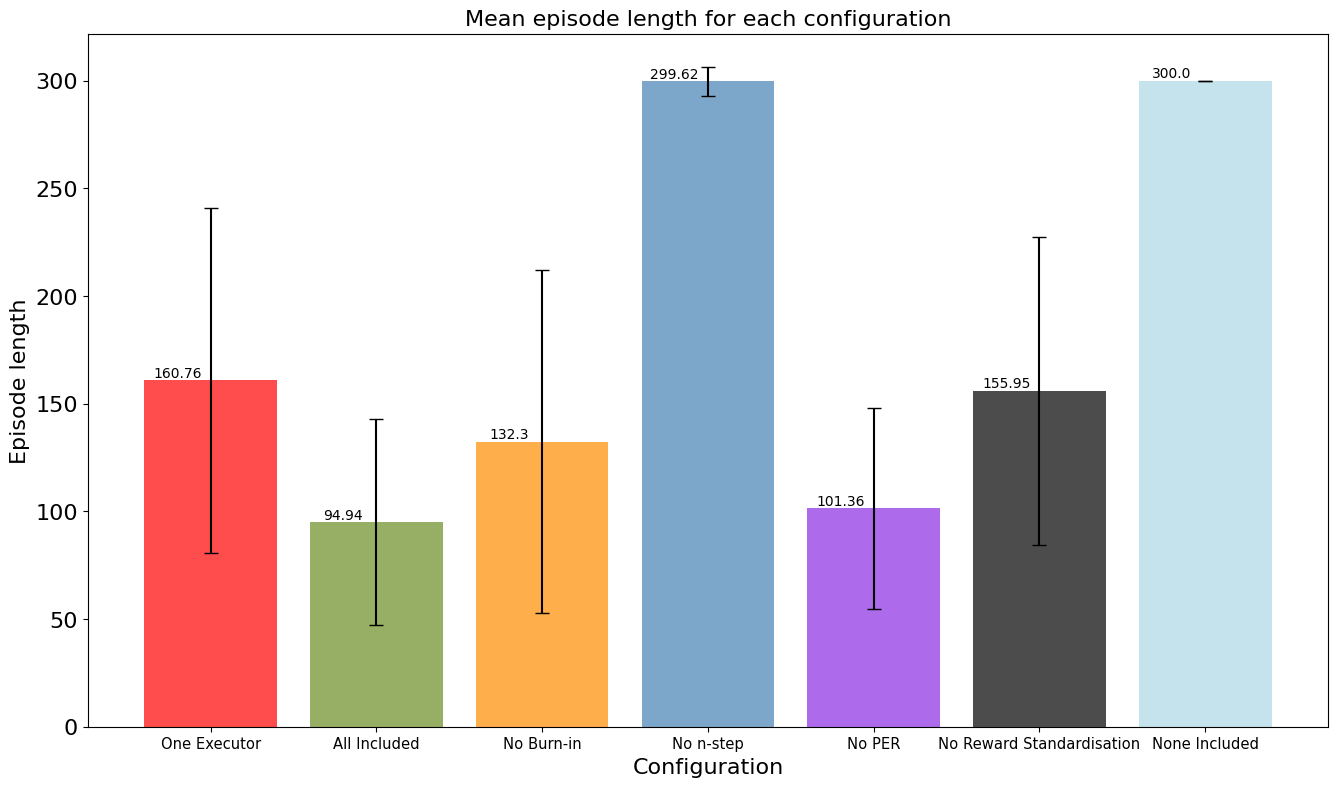

In [8]:
# loop throug eval_results and get the episode lengths, episode ids and rewards in each dir, then plot them all at the end

parent_dir = "./eval_results"
subfolders = [f for f in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, f))]
subfolders = sorted(subfolders)

labels = ["One Executor", "All Included", "No Burn-in", "No n-step", "No PER", "No Reward Standardisation", "None Included"]
all_episode_ids = []
all_episode_lengths = []
all_rewards = []

colours = ["red", "olivedrab", "darkorange", "steelblue", "blueviolet", "black", "lightblue"]

for subfolder in subfolders:
    episode_ids = np.load(f"{parent_dir}/{subfolder}/episode_id.npy")
    episode_lengths = np.load(f"{parent_dir}/{subfolder}/episode_length_data.npy")
    rewards = np.load(f"{parent_dir}/{subfolder}/rewards.npy")

    rewards_squeezed = np.squeeze(rewards, axis = (1,3))
    rewards_processed = np.sum(rewards_squeezed, axis=1)

    all_episode_ids.append(episode_ids)
    all_episode_lengths.append(episode_lengths)
    all_rewards.append(rewards_processed)

all_episode_ids = np.stack(all_episode_ids)
all_episode_lengths = np.stack(all_episode_lengths)
all_rewards = np.stack(all_rewards)

fig1, ax1 = plt.subplots()

fig2, ax2 = plt.subplots()

fig1.set_figwidth(16)
fig2.set_figwidth(16)
fig1.set_figheight(9)
fig2.set_figheight(9)


# Plot a bar chart:
all_rewards_mean = np.mean(all_rewards, axis = -1)
all_eplens_mean = np.mean(all_episode_lengths, axis = -1)

reward_stds = np.std(all_rewards, axis = -1)
eplen_stds = np.std(all_episode_lengths, axis = -1)


bars1 = ax1.bar(labels, all_rewards_mean, color = colours, yerr = reward_stds, capsize=5, alpha=0.7)
bars2 = ax2.bar(labels, all_eplens_mean, color = colours, yerr= eplen_stds, capsize=5, alpha=0.7)

for bar1, bar2 in zip(bars1, bars2):
    # yval = bar1.get_height()
    # ax1.text(bar1.get_x() + bar1.get_width()/2, yval+0.025, round(yval, 2), ha='center', va='bottom')
    # yval = bar2.get_height()
    # ax2.text(bar2.get_x() + bar2.get_width()/2, yval+0.025, round(yval, 2), ha='center', va='bottom')

    yval = bar1.get_height()
    ax1.text(bar1.get_x() + bar1.get_width()/4, yval+0.02, s=round(yval, 2), ha='center', va='bottom')
    yval = bar2.get_height()
    ax2.text(bar2.get_x() + bar2.get_width()/4, yval+0.02, s=round(yval, 2), ha='center', va='bottom')


# for i in range(all_episode_ids.shape[0]):
    # ax1.plot(all_episode_ids[i], all_rewards[i], color = colours[i], alpha = 0.2)
    # ax1.plot(all_episode_ids[i], np.ones_like(all_rewards[i]) * np.mean(all_rewards[i]), color = colours[i], linestyle = "dashed")
    
    # ax2.plot(all_episode_ids[i], all_episode_lengths[i], color = colours[i], alpha = 0.2)
    # ax2.plot(all_episode_ids[i], np.ones_like(all_rewards[i]) * np.mean(all_episode_lengths[i]), color = colours[i], linestyle = "dashed")

# fig2, ax2 = plt.subplots()
# ax2.plot(all_episode_ids, all_episode_lengths)

# ax1.grid(alpha=0.3)
# ax2.grid(alpha=0.3)
ax1.set_title("Mean cumulative reward for each configuration", fontsize=16)
ax2.set_title("Mean episode length for each configuration", fontsize=16)

ax1.tick_params(axis='x', labelsize=2/3*fontsize)
ax2.tick_params(axis='x', labelsize=2/3*fontsize)

ax1.tick_params(axis='y', labelsize=fontsize)
ax2.tick_params(axis='y', labelsize=fontsize)
# ax1.grid(alpha=0.3)
# ax2.grid(alpha=0.3)

ax1.set_xlabel("Configuration", fontsize=16)
ax2.set_xlabel("Configuration", fontsize=16)

ax1.set_ylabel("Reward value", fontsize=16)
ax2.set_ylabel("Episode length", fontsize=16)


fig1.savefig("figs/ablation_reward_bars.pdf")
fig2.savefig("figs/ablation_eplen_bars.pdf")



Transfer learning
16:9 aspect ratio


# Transfer Learning Results

['csv/Value_rescale_NoisyNet_ep_len/full_system', 'csv/Value_rescale_NoisyNet_ep_len/noisy_net', 'csv/Value_rescale_NoisyNet_ep_len/value_function_rescaling']
file_in_folder: csv/Value_rescale_NoisyNet_ep_len/full_system/full_system_ablation_env_1_tb_logs.csv
ys has 201 elements
file_in_folder: csv/Value_rescale_NoisyNet_ep_len/full_system/full_system_ablation_env_2_tb_logs.csv
ys has 201 elements


TypeError: _stack_dispatcher() got an unexpected keyword argument 'Value_rescale_NoisyNet_ep_lenaxis'

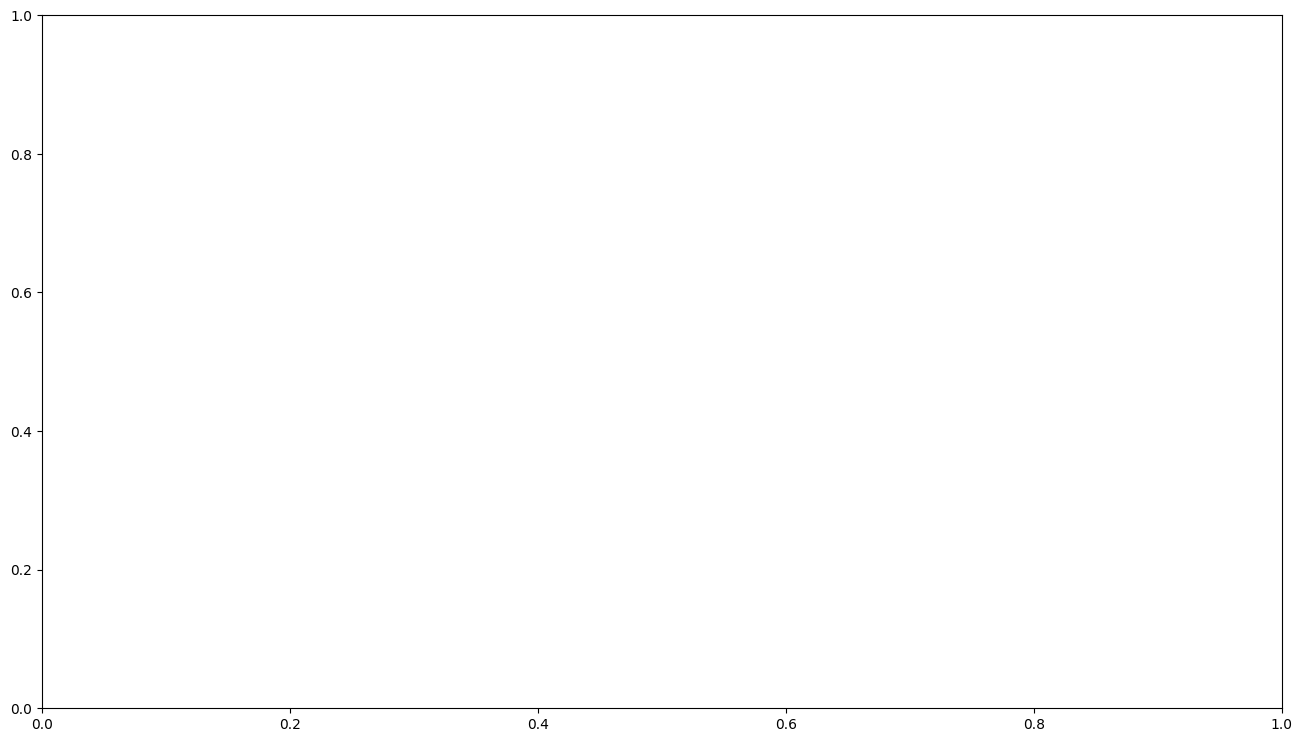

In [31]:
fontsize = 16
num_different_items_to_plot = 2

# parent_dirs = ["transfer_init_ep_len", "transfer_init_rewards"]
# labels = ["Full System"]
# x_steps = 5000
# eplen=300
# fontsize = 24

# parent_dirs = ["transfer_ep_len", "transfer_rewards"]
# labels = ["Curiosity", "Full System", "Transfer Learning", "Transfer Learning and Curiosity"]
# x_steps = 15000
# strong_transfer = 5000
# eplen = 500


# parent_dirs = ["full_act_init_ep_len", "full_act_init_rewards"]
# labels = ["Full System"]
# x_steps = 3000
# fontsize = 24


# parent_dirs = ["full_act_ep_len", "full_act_rewards"]
# labels = ["Full System", "Transferred Agent Models"]
# x_steps = 18000

# parent_dirs = ["appendix_full_act_ep_len", "appendix_full_act_rewards"]
# labels = ["Full System", "Transferred Agent Models"]
# x_steps = 15000





# parent_dirs = ["exp_5_ep_len", "exp_5_rewards"]
# labels = ["Full System", "Transfer Learning"]
# x_steps = 40000
# strong_transfer = 15000
# fontsize = 16
# eplen = 500

# parent_dirs = ["exp_5_full_ep_len", "exp_5_full_rewards"]
# labels = [ "Transfer Learning"]
# x_steps = 40000
# strong_transfer = 0
# fontsize = 16
# eplen = 500
# color = "orange"

# parent_dirs = ["SRUBRU_ep_len", "SRUBRU_rewards"]
# labels = ["Epsilon-greedy BRU", "Epsilon-greedy BSU","NoisyNet BRU", "NoisyNet BSU"]
# x_steps = 4000
# fontsize = 16
# eplen=300

parent_dirs = ["Value_rescale_NoisyNet_ep_len", "Value_rescale_NoisyNet_rewards"]
labels = ["Full System", "NoisyNet", "Value function rescaling"]
x_steps = 4000
fontsize = 16
eplen=300

# parent_dirs = ["SRU_vs_BRU_ep_len", "SRU_vs_BRU_rewards"]
# labels = ["Bootstrapped random updates", "Bootstrapped sequential updates"]
# x_steps = 4000
# fontsize = 16
# eplen=300




# parent_dirs = ["appendix_ablation_ep_len", "appendix_ablation_rewards"]
# labels = ["Full System", "Transferred Agent Models"]

# parent_dirs = ["appendix_coop_ep_len", "appendix_coop_rewards"]
# labels = ["Full System", "Transferred Agent Models"]
# x_steps = 40000


# parent_dirs = ["appendix_value_fn_rescale_and_full_system_ep_len", "appendix_value_fn_rescale_and_full_system_rewards"]
# labels = ["Full System", "Value Function Rescaling"]

# parent_dirs = ["appendix_transfer_ep_len", "appendix_transfer_rewards"]
# labels = ["Full System", "Transferred Agent Models"]

# plotting csv/transfer_ep_len/curiosity_no_transfer_tb_logs.csv
# plotting csv/transfer_ep_len/transfer_15k_withoutmodels_tb_logs.csv
# plotting csv/transfer_ep_len/transfer_success_withmodels_tb_logs.csv

num_ablation_studies = 1

for parent_dir in parent_dirs:
    sub_paths = []
    # path = f'csv/{parent_dir}/*.csv'
    path = f'csv/{parent_dir}/*'

    walltime_index = -1


    for fname in glob.glob(path):
        sub_paths.append(fname)

    # contains the sorted folder names
    sorted_sub_paths = sorted(sub_paths) 
    print(sorted_sub_paths)

    # labels = ["One Executor", "All Included", "No Burn-in", "No n-step", "No PER", "No Reward Standardisation", "None Included"]
    # colours = ["red", "olivedrab", "darkorange", "steelblue", "blueviolet", "black", "lightblue"]

    fig1, ax1 = plt.subplots()
    # fig2, ax2 = plt.subplots() #This is to plot it against  

    fig1.set_figwidth(16)
    # fig2.set_figwidth(16)
    fig1.set_figheight(9)
    # fig2.set_figheight(9)
    rr = []

    # for item in sorted_filenames:
    #     print(item)

    all_y = []
    y_means = []
    y_stddevs = []
    num_elements = int(x_steps/20+1)

    for sub_path in sorted_sub_paths:
        for file_in_folder in glob.glob(f"{sub_path}/*.csv"):
            print(f"file_in_folder: {file_in_folder}")
            walltime, steps, y = parse_csv(file_in_folder)
            all_y.append(y[:num_elements])
            
            print(f"ys has {len(y[:num_elements])} elements")

        y_means.append(np.mean(np.stack(all_y, Value_rescale_NoisyNet_ep_lenaxis=0), axis=0))
        y_stddevs.append(np.std(np.stack(all_y, axis=0), axis=0))
        all_y.clear()


    steps = steps[:num_elements]
    for mean_y, stddev_y, label in zip(y_means, y_stddevs, labels):
        if "transfer" in label or "Transfer" in label:
            pltsteps = [i+strong_transfer for i in steps]
            ax1.plot(pltsteps, smooth(mean_y, 0.5) , label=label,color = "C1")
            # ax1.fill_between(pltsteps, smooth(mean_y, 0.5)-stddev_y, smooth(mean_y, 0.5)+stddev_y, edgecolor=None, alpha=0.1)
            fill_lower = mean_y-stddev_y
            fill_lower = np.clip(fill_lower, -1, eplen)

            fill_upper = mean_y+stddev_y
            fill_upper = np.clip(fill_upper, -1, eplen)
            ax1.fill_between(pltsteps, fill_lower, fill_upper, edgecolor=None, alpha=0.1, facecolor="C1")
        else:
            ax1.plot(steps, smooth(mean_y, 0.5) , label=label)
            ax1.fill_between(steps, smooth(mean_y, 0.0)-stddev_y, smooth(mean_y, 0.0)+stddev_y, edgecolor=None, alpha=0.1)

        
    

    if "reward" in parent_dir:
        ax1.set_ylabel("Mean Cumulative Episode Reward", fontsize=fontsize)
        ax1.set_title("Mean Reward vs Trainer Steps", fontsize=fontsize)
    if "ep_len" in parent_dir:
        ax1.set_ylabel("Mean Episode Length", fontsize=fontsize)
        ax1.set_title("Mean Episode Length vs Trainer Steps", fontsize=fontsize)


    ax1.grid(alpha = 0.3)
    if len(labels)>1:
        ax1.legend(loc = "upper left", fontsize=fontsize)
    ax1.set_xlabel("Trainer Steps", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    ax1.set_xbound(0,x_steps)
    # print(f"Done plotting {item}")

    fig1.savefig(f"figs/{parent_dir}.pdf")
        





# Activation Functions

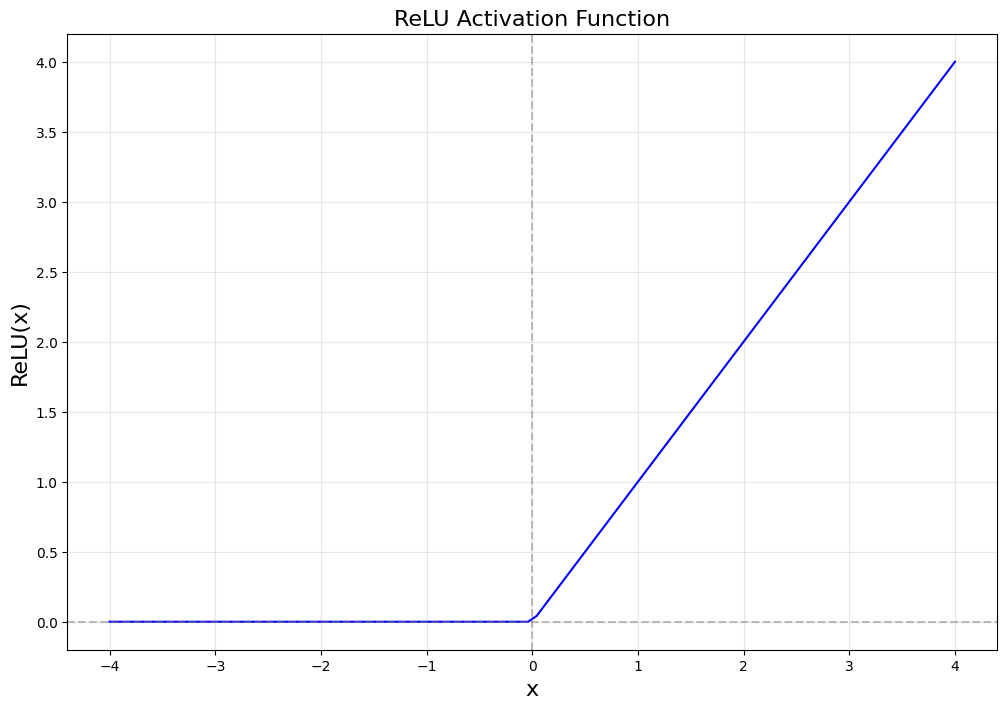

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def elu(x):
    if x > 0 :
        return x
    else : 
        return (np.exp(x)-1)

def der_elu(x):
    if x > 0 :
        return 1
    else :
        return np.exp(x)
    
def relu(x):
    return max(0,x)
    
x = np.linspace(-4,4,100)


fig,ax = plt.subplots(figsize=(12,8))
# ax.plot(x, list(map(lambda x: elu(x),x)), label="elu", color="blue")
ax.plot(x, list(map(lambda x: relu(x),x)), label="ReLU", color="blue")
plt.axhline(y=0.0, color='grey', linestyle='--', alpha=0.5)
plt.axvline(x=0.0, color='grey', linestyle='--', alpha=0.5)
ax.set_title("ReLU Activation Function", fontsize=fontsize)
ax.set_ylabel("ReLU(x)", fontsize=fontsize)
ax.set_xlabel("x", fontsize=fontsize)
ax.grid(alpha=0.3)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.savefig("figs/relu.pdf")



In [11]:
list1 = np.ones(751,)
list2 = np.zeros(751,)

lists = [list1, list2]

print(np.mean(np.stack(lists, axis=0), axis=0))

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.